In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [14]:
# Load and preprocess the data
data_dir = 'balanced_data'

# Set the image size to 160x160 to align with MobileNetV2's expected input size
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 32

In [15]:
# Load dataset with a validation split = 30%
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
    validation_split=0.3,
    subset='training'
)

val_test_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
    validation_split=0.3,
    subset='validation'
)

Found 51555 files belonging to 22 classes.
Using 36089 files for training.
Found 51555 files belonging to 22 classes.
Using 15466 files for validation.


In [16]:
# Get the class names before mapping
class_names = data.class_names

In [17]:
# Split the val_test_data into validation and test sets
val_batches = tf.data.experimental.cardinality(val_test_data)
test_size = val_batches // 2
val_data = val_test_data.skip(test_size)
test_data = val_test_data.take(test_size)

In [18]:
# Normalize the images
data = data.map(lambda x, y: (x / 255.0, tf.one_hot(y, len(class_names))))
val_data = val_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, len(class_names))))
test_data = test_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, len(class_names))))

In [19]:
# Load pre-trained MobileNetV2 model + higher level layers
weights_path = 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5'
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights=None)
base_model.load_weights(weights_path)
base_model.trainable = False  # Freeze the base model

In [20]:
# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Implement Early Stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [22]:
# Train the model

Epoch 1/100
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 156s 137ms/step - accuracy: 0.4718 - loss: 1.8091 - val_accuracy: 0.8223 - val_loss: 0.5699 - learning_rate: 1.0000e-04
Epoch 2/100
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 205s 181ms/step - accuracy: 0.7809 - loss: 0.6627 - val_accuracy: 0.8678 - val_loss: 0.4106 - learning_rate: 1.0000e-04
Epoch 3/100
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 216s 192ms/step - accuracy: 0.8316 - loss: 0.4941 - val_accuracy: 0.8884 - val_loss: 0.3384 - learning_rate: 1.0000e-04
Epoch 4/100
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 235s 208ms/step - accuracy: 0.8626 - loss: 0.4018 - val_accuracy: 0.8983 - val_loss: 0.2951 - learning_rate: 1.0000e-04
Epoch 5/100
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 234s 208ms/step - accuracy: 0.8795 - loss: 0.3487 - val_accuracy: 0.9060 - val_loss: 0.2732 - learning_rate: 1.0000e-04
Epoch 6/100
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 220s 195ms/step - accuracy: 0.8925 - loss: 0.3148 - val_accuracy: 0.9116 - val_loss: 0.2465 - learning_rate: 1.0000e-04
Epoch 7/100
1128/1128 

In [23]:
# Unfreeze some layers in the base model for fine-tuning
base_model.trainable = True
fine_tune_at = 100  # Fine-tune from this layer onwards

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Continue training the model
history_fine = model.fit(data, validation_data=val_data, epochs=50, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 542s 477ms/step - accuracy: 0.4329 - loss: 5.1822 - val_accuracy: 0.8054 - val_loss: 0.6805 - learning_rate: 1.0000e-05
Epoch 2/50
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 617s 547ms/step - accuracy: 0.7497 - loss: 0.8585 - val_accuracy: 0.8581 - val_loss: 0.4330 - learning_rate: 1.0000e-05
Epoch 3/50
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 372s 329ms/step - accuracy: 0.8211 - loss: 0.5306 - val_accuracy: 0.8906 - val_loss: 0.2999 - learning_rate: 1.0000e-05
Epoch 4/50
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 404s 358ms/step - accuracy: 0.8645 - loss: 0.3868 - val_accuracy: 0.9064 - val_loss: 0.2391 - learning_rate: 1.0000e-05
Epoch 5/50
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 437s 387ms/step - accuracy: 0.8849 - loss: 0.3142 - val_accuracy: 0.9184 - val_loss: 0.2021 - learning_rate: 1.0000e-05
Epoch 6/50
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 427s 378ms/step - accuracy: 0.9079 - loss: 0.2439 - val_accuracy: 0.9284 - val_loss: 0.1799 - learning_rate: 1.0000e-05
Epoch 7/50
1128/1128 ━━━━━━━

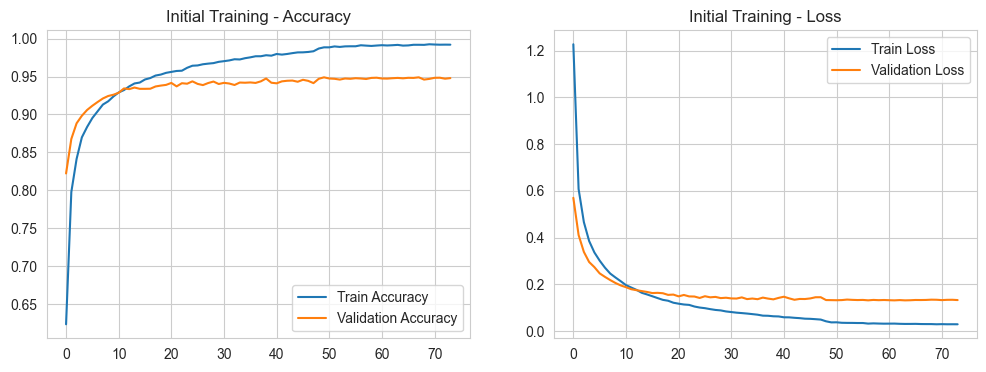

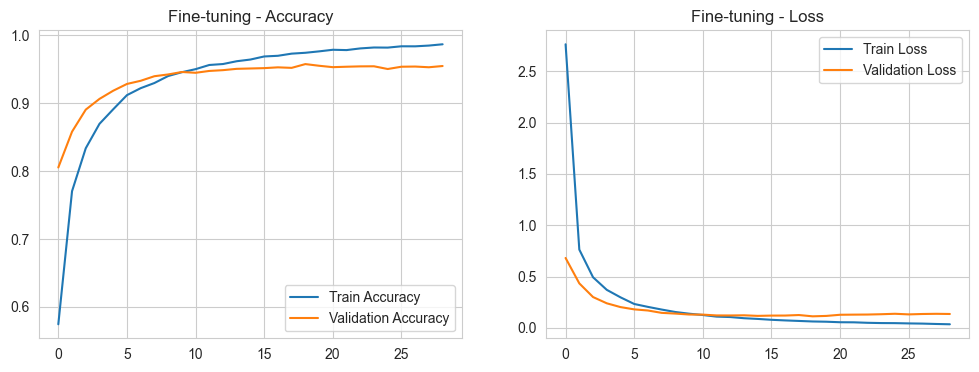

In [25]:
# Plot the training history
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.legend()
    ax1.set_title(f'{title} - Accuracy')

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.legend()
    ax2.set_title(f'{title} - Loss')

    plt.show()

plot_history(history, 'Initial Training')
plot_history(history_fine, 'Fine-tuning')

In [26]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_data)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

242/242 ━━━━━━━━━━━━━━━━━━━━ 43s 160ms/step - accuracy: 0.9538 - loss: 0.1191
Validation Accuracy: 95.74%
242/242 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - accuracy: 0.9508 - loss: 0.1251
Test Accuracy: 95.03%


In [27]:
# Generate confusion matrix for the test set
test_data_unbatched = test_data.unbatch()
y_pred = []
y_true = []

for x, y in test_data_unbatched:
    x = tf.expand_dims(x, axis=0)
    pred = model.predict(x)
    y_pred.append(np.argmax(pred))
    y_true.append(np.argmax(y.numpy()))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Ensure the true and predicted labels contain the same number of classes
all_classes = np.arange(len(class_names))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=all_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

2024-06-07 01:59:26.865203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Confusion matrix, without normalization


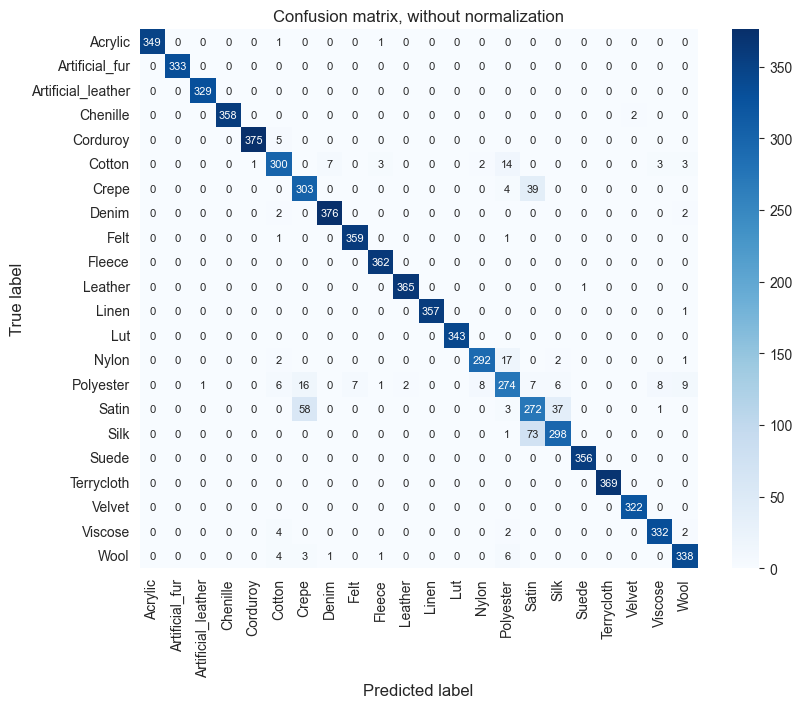

Normalized confusion matrix


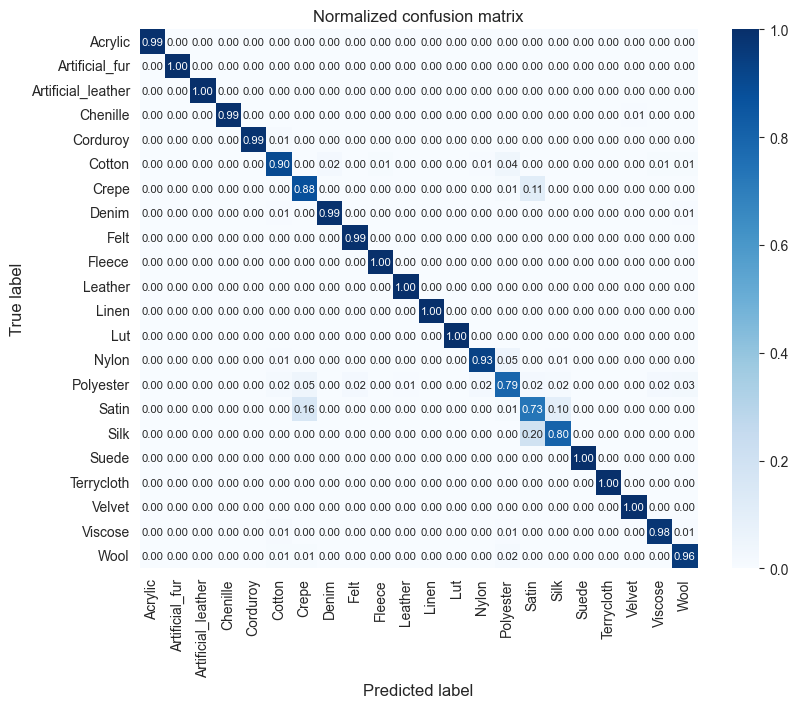

In [28]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        with np.errstate(all='ignore'):
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cm = np.nan_to_num(cm)  # Replace nan with 0 and inf with large finite numbers
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    plt.figure(figsize=(9, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap, xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})
    plt.title(title, fontsize=12)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')


In [29]:
import os

# File path for the saved model
model_file_path = './models/fabric_classification_model_oversampling.keras'  # Changed the file name to ensure it doesn't exist

# Check if the file already exists and remove it (optional, since we are using a new name)
if os.path.exists(model_file_path):
    os.remove(model_file_path)

# Save the trained model to a file using the recommended format
model.save(model_file_path)